# mpcpy Workflow

In a model predictive control simulation we need several components. At first we need an emulator to replace the real world system in our computational environment. The system is subjected to certain boundary conditions which may vary. Next we need a controller which will determine the inputs we must supply to the emulated system so it moves in the wanted direction. As we are considering MPC the controller will consist of a state estimation, a prediction and an optimization

For each of these components base classes are included in mpcpy. Some of these classes can be used out off the box, others require child class creation which will be explained below.

before we start import numpy, matplotlib, pyomo which will be used for the optimization and mpcpy

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyomo

import mpcpy

## Boundary conditions

As all systems are subject to some boundary conditions a Boundaryconditions class is constructed.
This class main purpose is to handle the interpolation of boundary conditions to the correct times (also for predictions which may lay outside of the emulation interval).
By default it assumes periodic boundary conditions but this can be altered to maintaining the first or last entry when time flows outside of the defined range by setting `periodic=False` as an argument on creation.

#### Example:

In [2]:
time = np.arange(0.,24.01*3600.,3600.)
bcs = {
    'time': time,
    'T_am': 5 + 2*np.sin(2*np.pi*time/24./3600.)+273.15,
    'Q_flow_so': 500 + 500*np.sin(2*np.pi*time/24./3600.),
    'p_el': 0.2 + 0.05*np.sin(2*np.pi*time/24./3600.),
    'Q_flow_hp_max': 5000*np.ones_like(time),
    'T_in_min': 20*np.ones_like(time)+273.15,
    'T_em_max': 30*np.ones_like(time)+273.15
}

boundaryconditions = mpcpy.Boundaryconditions(bcs,periodic=False)

# test
print( boundaryconditions(1800) ) 
print( boundaryconditions(24.5*3600) )  # extrapolation

{'Q_flow_hp_max': 5000.0, 'p_el': 0.20647047612756303, 'T_am': 278.4088190451025, 'T_em_max': 303.15, 'time': 1800.0, 'Q_flow_so': 564.7047612756302, 'T_in_min': 293.15}
{'Q_flow_hp_max': 5000.0, 'p_el': 0.20000000000000004, 'T_am': 278.15, 'T_em_max': 303.15, 'time': 88200.0, 'Q_flow_so': 500.00000000000034, 'T_in_min': 293.15}


## Emulator

The emulator class creates objects used to emulate the system.
By default the values returned from the control optimization are retained.
A [dympy](https://github.com/brechtba/dympy) Dymola connector is also available to do the simulation work or the class can be adapted, in a subclass, to use other simulation tools.
When creating an object the inputs the model uses need to be specified as a list of strings. These inputs can be controlled inputs or disturbances.

The object must have a `res` property where the results of the entire emulation are stored. This property is later used to output the results to the mpcpy object.

Model parameters can be defined using the `set_parameters` method which accepts a dictionary with name, value pairs as argument. 
Initial conditions can be defined using the `set_initial_conditions` method which accepts a dictionary with name, value pairs as argument.

Each model must be initialized before a simulation or mpc run using the `initialize`.
The initialization sets all parameter values and initial conditions and runs the simulation for a short period to get initial values for all variables in the `res` dictionary.
This way rewriting all parameters before every emulation is avoided which results in considerable speed gains.

The most important method in the emulator class it the `__call__` method.
This method should accepts an input dictionary with inputs to the emulator as only argument and append the results to it's `res` property.

#### Example:

Let's create a simple simulation model using a fixed timestep forward integration method.
The only thing we have to do is to redefine the simulate method:

In [3]:
class Emulator(mpcpy.Emulator):
    """
    A custom system emulator
    """
    def simulate(self,starttime,stoptime,input):
        dt = 60
        time = np.arange(starttime,stoptime+dt,dt,dtype=np.float)

        # initialize
        T_em = np.ones_like(time)*self.res['T_em'][-1]
        T_in = np.ones_like(time)*self.res['T_in'][-1]
        
        # interpolate inputs
        Q_flow_hp = np.interp(time,input['time'],input['Q_flow_hp'])
        Q_flow_so = np.interp(time,input['time'],input['Q_flow_so'])
        T_am      = np.interp(time,input['time'],input['T_am'])
        
        for i,t in enumerate(time[:-1]):
            # C_em dT_em/dt = Q_flow_hp - UA_em_in*(T_em-T_in)
            T_em[i+1] = T_em[i] + ( Q_flow_hp[i] - self.parameters['UA_em_in']*(T_em[i]-T_in[i]) )*dt/self.parameters['C_em']
        
            # C_in dT_in/dt = Q_flow_so - UA_em_in*(T_in-T_em) - UA_in_am*(T_in-T_am)
            T_in[i+1] = T_in[i] + ( Q_flow_so[i] - self.parameters['UA_em_in']*(T_in[i]-T_em[i]) -+ self.parameters['UA_in_am']*(T_in[i]-T_am[i]) )*dt/self.parameters['C_em']
            
            
        # create and return a results dict    
        res = {
            'time': time,
            'Q_flow_hp':Q_flow_hp,
            'Q_flow_so':Q_flow_so,
            'T_em':T_em,
            'T_in':T_in,
            'T_am':T_am,
        }
        
        return res

Now we create an instance of this emulator and set parameters and initial conditions:

In [4]:
emulator = Emulator(['T_am','Q_flow_so','Q_flow_hp'])

emulator_parameters = {
    'C_em': 10e6, 
    'C_in': 5e6, 
    'UA_in_am': 200, 
    'UA_em_in': 1600
}
emulator.set_parameters(emulator_parameters)


emulator_initialconditions = {
    'T_em': 22+273.15,
    'T_in': 21+273.15
}
emulator.set_initial_conditions(emulator_initialconditions)

emulator.initialize()

# test
# some input signals for testing
inp = {
    'time': [0., 3600., 7200.], 
    'T_am': [273.15, 274.15, 275.15], 
    'Q_flow_so': [500., 400., 300.], 
    'Q_flow_hp': [4000., 4000., 4000.]
}

emulator(np.arange(0.,7201.,1200.),inp)

print( emulator.res['time'] )
print( emulator.res['T_em'] )

[    0.  1200.  2400.  3600.  4800.  6000.  7200.]
[ 295.15        295.39422931  295.56712793  295.69275797  295.78723691
  295.86135873  295.92235032]


## Control

The control algorithm is MPC by default as this is the goal of the project, but it could be modified to use other control techniques at discrete time intervals.
An MPC consists of a state estimation, a prediction and a control optimization which will be explained below.

The basic principle of MPC is that a model suitable for optimization (for instance a linear or quadratic program or a smooth non-convex model) which represents the system behavior is constructed.
Each time step the states of the optimization model are estimated based on measurements or the emulation model in our case.
A prediction is made for the disturbances over a certain time period (the control horizon).
The model is optimized with respect to the control signals given the predictions and certain constraints and the first sample of the control signals are implemented in the emulator.
The system hopefully evolves in the desired direction and the next time step everything starts over.

- refs on mpc

### State estimation
We start by defining a state estimation object. A base class is supplied in mpcpy but due to the specific nature of every model this has to be extended for every MPC.

During creation the estimation object has to be given an emulator object which contains the results from which the states can be estimated.
The implemented `__call__` method take one argument, time, and simply passes this to the `stateestimation` method and returns the result.

The intention is that the `stateestimation` method can be modified in a child class without affecting the overall object behavior and multiple state estimation objects can be created and used.

#### Example:

In [5]:
class Stateestimation_perfect(mpcpy.Stateestimation):
    """
    Custom state estimation method
    """ 
    def stateestimation(self,time):
        state = {}
        state['T_in'] = np.interp(time,self.emulator.res['time'],self.emulator.res['T_in'])
        state['T_em'] = np.interp(time,self.emulator.res['time'],self.emulator.res['T_em'])
        
        return state

stateestimation = Stateestimation_perfect(emulator)

# test
print( stateestimation(0) )

{'T_in': 294.15, 'T_em': 295.15}


### Prediction
The `Prediction` class is used to generate predictions from the boundary conditions over a certain time period.

On creation it takes a `boundaryconditions` object as argument.
It follows the same structure as the `Stateestimation` class but is predefined with a perfect prediction method.

This can of course be redefined to more realistic or stochastic prediction models.

#### Example:

In [6]:
prediction = mpcpy.Prediction(boundaryconditions)

# test
print( prediction([0.,1800.,3600.]) )

{'Q_flow_hp_max': array([ 5000.,  5000.,  5000.]), 'p_el': array([ 0.2       ,  0.20647048,  0.21294095]), 'T_am': array([ 278.15      ,  278.40881905,  278.66763809]), 'T_em_max': array([ 303.15,  303.15,  303.15]), 'time': array([    0.,  1800.,  3600.]), 'Q_flow_so': array([ 500.        ,  564.70476128,  629.40952255]), 'T_in_min': array([ 293.15,  293.15,  293.15])}


### Control
The `Control` class combines state estimations and predictions and solves an optimal control problem.
The class is built as a base class as the optimal control program will be different for every system.
Upon initialization a `stateestimation` object, `prediction` object must be given. Several other arguments are optional.
A `parameters=None` argument can be used to pass model parameters to the optimal control problem.
The `horizon=24*3600.` argument determines how far the optimal control problem will look into the future.
The `timestep=3600.` argument determines the discretization time step of the optimal control problem.
The `receding=3600.` argument determines the time between two control optimizations

A `time` method is implemented which creates a control time array for the next control optimization based on a `starttime` argument and the above mentioned times.
The `__call__` method runs the state estimation, the predictions and tries to solve the optimal control problem.
The solving of the optimal control problem is done by calling the `solution` method which solves the problem and returns a dictionary of control inputs.

In the `formulation` method is executed during the first call to the control function and can be used to define helping elements which do not change during the MPC. This can be used to avoid redefining the problem on every control time step which could be very slow for large optimal control problems.

The base class the `solution` and `formulation` methods are blank so they need to be customized in a child class. 

#### Example:

In [7]:
class Linearprogram(mpcpy.Control):
    def formulation(self):
        """
        formulates the abstract optimal control problem
        """
        model = pyomo.AbstractModel()

        # sets
        model.i = pyomo.Set()   # initialize=range(len(time)-1)
        model.ip = pyomo.Set()  # initialize=range(len(time))

        # parameters
        model.time = pyomo.Param(model.ip)

        model.UA_em_in = pyomo.Param(initialize=800.)
        model.UA_in_am = pyomo.Param(initialize=200.)

        model.C_in = pyomo.Param(initialize=5.0e6)
        model.C_em = pyomo.Param(initialize=20.0e6)

        model.T_in_ini = pyomo.Param(initialize=21.+273.15)
        model.T_em_ini = pyomo.Param(initialize=22.+273.15)

        model.T_in_min = pyomo.Param(initialize=20.+273.15)
        model.T_in_max = pyomo.Param(initialize=24.+273.15)

        model.T_am = pyomo.Param(model.i, initialize=0.+273.15)
        model.Q_flow_so = pyomo.Param(model.i, initialize=0.)

        
        # variables
        model.T_in = pyomo.Var(model.ip,domain=pyomo.Reals, initialize=20.+273.15)
        model.T_em = pyomo.Var(model.ip,domain=pyomo.Reals,initialize=20.+273.15)
        
        model.T_in_min_slack = pyomo.Var(model.ip,domain=pyomo.NonNegativeReals, initialize=0)
        model.T_in_max_slack = pyomo.Var(model.ip,domain=pyomo.NonNegativeReals, initialize=0)
        
        model.Q_flow_hp = pyomo.Var(model.i,domain=pyomo.NonNegativeReals,bounds=(0.,10000.),initialize=0.)


      
        # constraints
        model.state_T_em = pyomo.Constraint(
            model.i,
            rule=lambda model,i: model.C_em*(model.T_em[i+1]-model.T_em[i])/(model.time[i+1]-model.time[i]) == \
                          model.Q_flow_hp[i] \
                        - model.UA_em_in*(model.T_em[i]-model.T_in[i])
        )
        model.ini_T_em = pyomo.Constraint(rule=lambda model: model.T_em[0] == model.T_em_ini)

        
        model.state_T_in = pyomo.Constraint(
            model.i,
            rule=lambda model,i: model.C_in*(model.T_in[i+1]-model.T_in[i])/(model.time[i+1]-model.time[i]) == \
                          model.Q_flow_so[i] \
                        - model.UA_em_in*(model.T_in[i]-model.T_em[i]) \
                        - model.UA_in_am*(model.T_in[i]-model.T_am[i])
        )
        model.ini_T_in = pyomo.Constraint(rule=lambda model: model.T_in[0] == model.T_in_ini)
        
        
        # soft constraints
        model.constraint_T_in_min_slack = pyomo.Constraint(
            model.ip,
            rule=lambda model,i: model.T_in_min_slack[i] >= model.T_in_min-model.T_in[i]
        )
        
        model.constraint_T_in_max_slack = pyomo.Constraint(
            model.ip,
            rule=lambda model,i: model.T_in_max_slack[i] >= model.T_in[i]-model.T_in_max
        )
        
        # a large number
        L = 1e6
        
        # objective
        model.objective = pyomo.Objective(
            rule=lambda model: sum(model.Q_flow_hp[i]*(model.time[i+1]-model.time[i])/3600/1000 for i in model.i) \
                              +sum(model.T_in_min_slack[i]*(model.time[i+1]-model.time[i])/3600 for i in model.i)*L\
                              +sum(model.T_in_max_slack[i]*(model.time[i+1]-model.time[i])/3600 for i in model.i)*L\
        )
    
        self.model = model
        
    def solution(self,sta,pre):
        """
        instanciate the optimal control problem, solve it and return a solution dictionary
        """
        
        ip = np.arange(len(pre['time']))
        
        data = {
            None:{
                'i':{None: ip[:-1]},
                'ip':{None: ip},
                'time':{(i,): v for i,v in enumerate(pre['time'])},
                'T_am':{(i,): pre['T_am'][i] for i in ip[:-1]},
                'Q_flow_so':{(i,): pre['Q_flow_so'][i] for i in ip[:-1]},  
                'T_em_ini': {None: sta['T_em']},
                'T_in_ini': {None: sta['T_in']},
                'C_em': {None: self.parameters['C_em']},
                'C_in': {None: self.parameters['C_in']},
                'UA_em_in': {None: self.parameters['UA_em_in']},    
                'UA_in_am': {None: self.parameters['UA_in_am']},
            }
        }
        
        instance = self.model.create_instance(data)
        optimizer = pyomo.SolverFactory('cplex')
        results = optimizer.solve(instance)
        
        # return the contol inputs
        sol = {
            'time': np.array([pyomo.value(instance.time[i]) for i in instance.ip]),
            'T_em': np.array([pyomo.value(instance.T_em[i]) for i in instance.ip]),
            'T_in': np.array([pyomo.value(instance.T_in[i]) for i in instance.ip]),
            'Q_flow_hp': np.array([pyomo.value(instance.Q_flow_hp[i]) for i in instance.i]),
        }

        return sol

    
# define parameters for the control instance
control_parameters = {
    'C_in': emulator_parameters['C_in'],
    'C_em': emulator_parameters['C_em'],
    'UA_in_am': emulator_parameters['UA_in_am'],
    'UA_em_in': emulator_parameters['UA_em_in'],
}
# create an instance
control = Linearprogram(
    stateestimation,
    prediction,
    parameters=control_parameters,
    horizon=24*3600.,
    timestep=3600.,
    receding=3600.
)
# test
print( control(0) )

{'Q_flow_hp': array([  128.77425437,  1494.47193837,  1726.3956544 ,  1615.29354912,
        1564.48272643,  1577.42585992,  1653.24089642,  1786.7611665 ,
        1968.8874844 ,  2187.20824254,  2426.84524203,  2671.46761738,
        2904.40475797,  3109.78238262,  3273.6043456 ,  3384.70645088,
        3435.51727357,  3422.57414008,  3346.75910358,  3213.2388335 ,
        3031.1125156 ,  2812.79175746,     0.        ,     0.        ]), 'T_in': array([ 294.15      ,  293.358     ,  293.15      ,  293.15      ,
        293.15      ,  293.15      ,  293.15      ,  293.15      ,
        293.15      ,  293.15      ,  293.15      ,  293.15      ,
        293.15      ,  293.15      ,  293.15      ,  293.15      ,
        293.15      ,  293.15      ,  293.15      ,  293.15      ,
        293.15      ,  293.15      ,  293.15      ,  293.15      ,
        292.08286126]), 'T_em': array([ 295.15      ,  294.62035873,  294.43125   ,  294.31475244,
        294.22536071,  294.16916672,  294.15     

## MPC
Everything comes together in the `MPC` class. This creates a callable object which runs the MPC and returns a result dictionary from the emulator.

In [8]:
mpc = mpcpy.MPC(
    emulator,
    control,
    boundaryconditions,
    emulationtime=1*24*3600.,
    resulttimestep=60
)

#run the mpc
res = mpc()

Run MPC                                                                        |
--------------------------------------------------------------------------------  done


Finally create a plot of the results

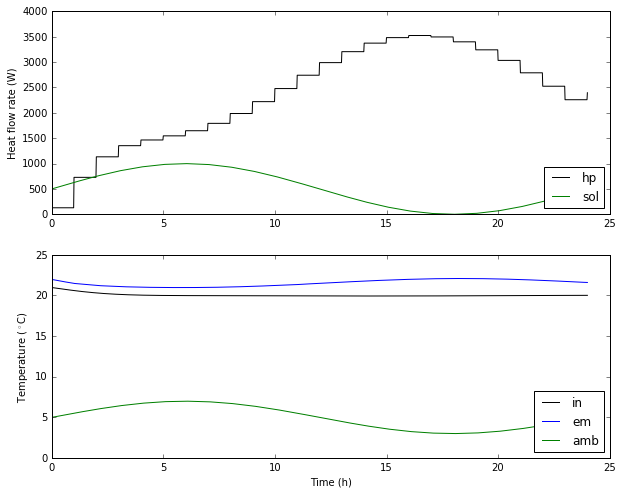

In [9]:
plt.figure(figsize=(10,8))
ax = plt.subplot(211)
ax.plot(res['time']/3600,res['Q_flow_hp'],'k',label='hp')
ax.plot(res['time']/3600,res['Q_flow_so'],'g',label='sol')
ax.set_ylabel('Heat flow rate (W)')
plt.legend(loc='lower right')

ax = plt.subplot(212)
ax.plot(res['time']/3600,res['T_in']-273.17,'k',label='in')
ax.plot(res['time']/3600,res['T_em']-273.17,'b',label='em')
ax.plot(res['time']/3600,res['T_am']-273.17,'g',label='amb')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Time (h)')
plt.legend(loc='lower right')

### Using the default emulator

The default emulator simply reuses the control solution. The results are a bit different due to model mismatch.

In [10]:
def_emulator = mpcpy.Emulator(['T_am','Q_flow_so','Q_flow_hp','T_in','T_em'])
def_emulator.set_initial_conditions(emulator_initialconditions)

def_stateestimation = Stateestimation_perfect(def_emulator)
def_control = Linearprogram(
    def_stateestimation,
    prediction,
    parameters=control_parameters,
    horizon=24*3600.,
    timestep=3600.,
    receding=3600.
)
def_mpc = mpcpy.MPC(
    def_emulator,
    def_control,
    boundaryconditions,
    emulationtime=1*24*3600.,
    resulttimestep=60
)

# run the mpc
def_res = def_mpc()

Run MPC                                                                        |
--------------------------------------------------------------------------------  done


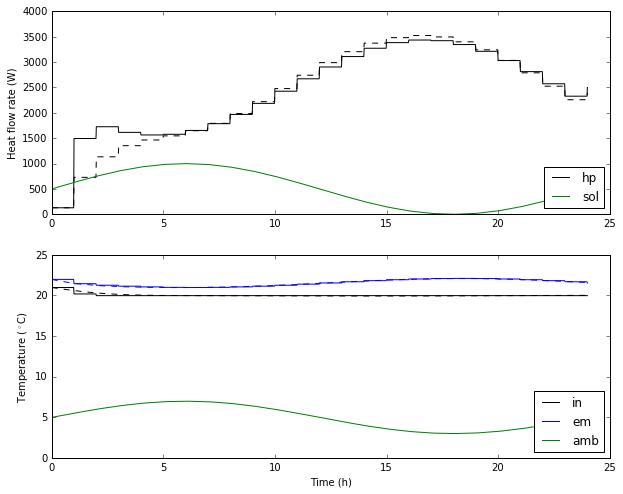

In [11]:
plt.figure(figsize=(10,8))
ax = plt.subplot(211)
ax.plot(def_res['time']/3600,def_res['Q_flow_hp'],'k',label='hp')
ax.plot(res['time']/3600,res['Q_flow_hp'],'k--')
ax.plot(def_res['time']/3600,def_res['Q_flow_so'],'g',label='sol')
ax.set_ylabel('Heat flow rate (W)')
plt.legend(loc='lower right')

ax = plt.subplot(212)
ax.plot(def_res['time']/3600,def_res['T_in']-273.17,'k',label='in')
ax.plot(def_res['time']/3600,def_res['T_em']-273.17,'b',label='em')
ax.plot(def_res['time']/3600,def_res['T_am']-273.17,'g',label='amb')
ax.plot(res['time']/3600,res['T_in']-273.17,'k--')
ax.plot(res['time']/3600,res['T_em']-273.17,'b--')
ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_xlabel('Time (h)')
plt.legend(loc='lower right')